# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

We install the necessary libraries for our deep learning project, including transformers for working with language models, datasets for handling data, evaluate for assessment metrics, accelerate for optimization, peft for parameter-efficient fine-tuning, trl for reinforcement learning, and bitsandbytes for memory efficiency. We also try to install NVIDIA ML Python utilities.

In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

We import all required packages for our project: os for system operations, pandas for data manipulation, torch for deep learning, various RoBERTa components from transformers, PEFT modules for efficient fine-tuning, dataset handling utilities, and pickle for data serialization.

## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

We set up our RoBERTa tokenizer and preprocess the AG News dataset. We specify 'roberta-base' as our foundation model, load the AG News dataset, initialize the tokenizer, define a preprocessing function that tokenizes text inputs with truncation and padding, apply this to our dataset in batches, and rename the "label" column to "labels" for compatibility with the Hugging Face Trainer API.

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")




```
number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']
```



We extract classification metadata from our dataset, identifying that we have 4 news categories (World, Sports, Business, Sci/Tech). We create an id2label mapping dictionary to translate between numeric indices and human-readable class names, and initialize a data collator that will handle padding when creating batches for training.

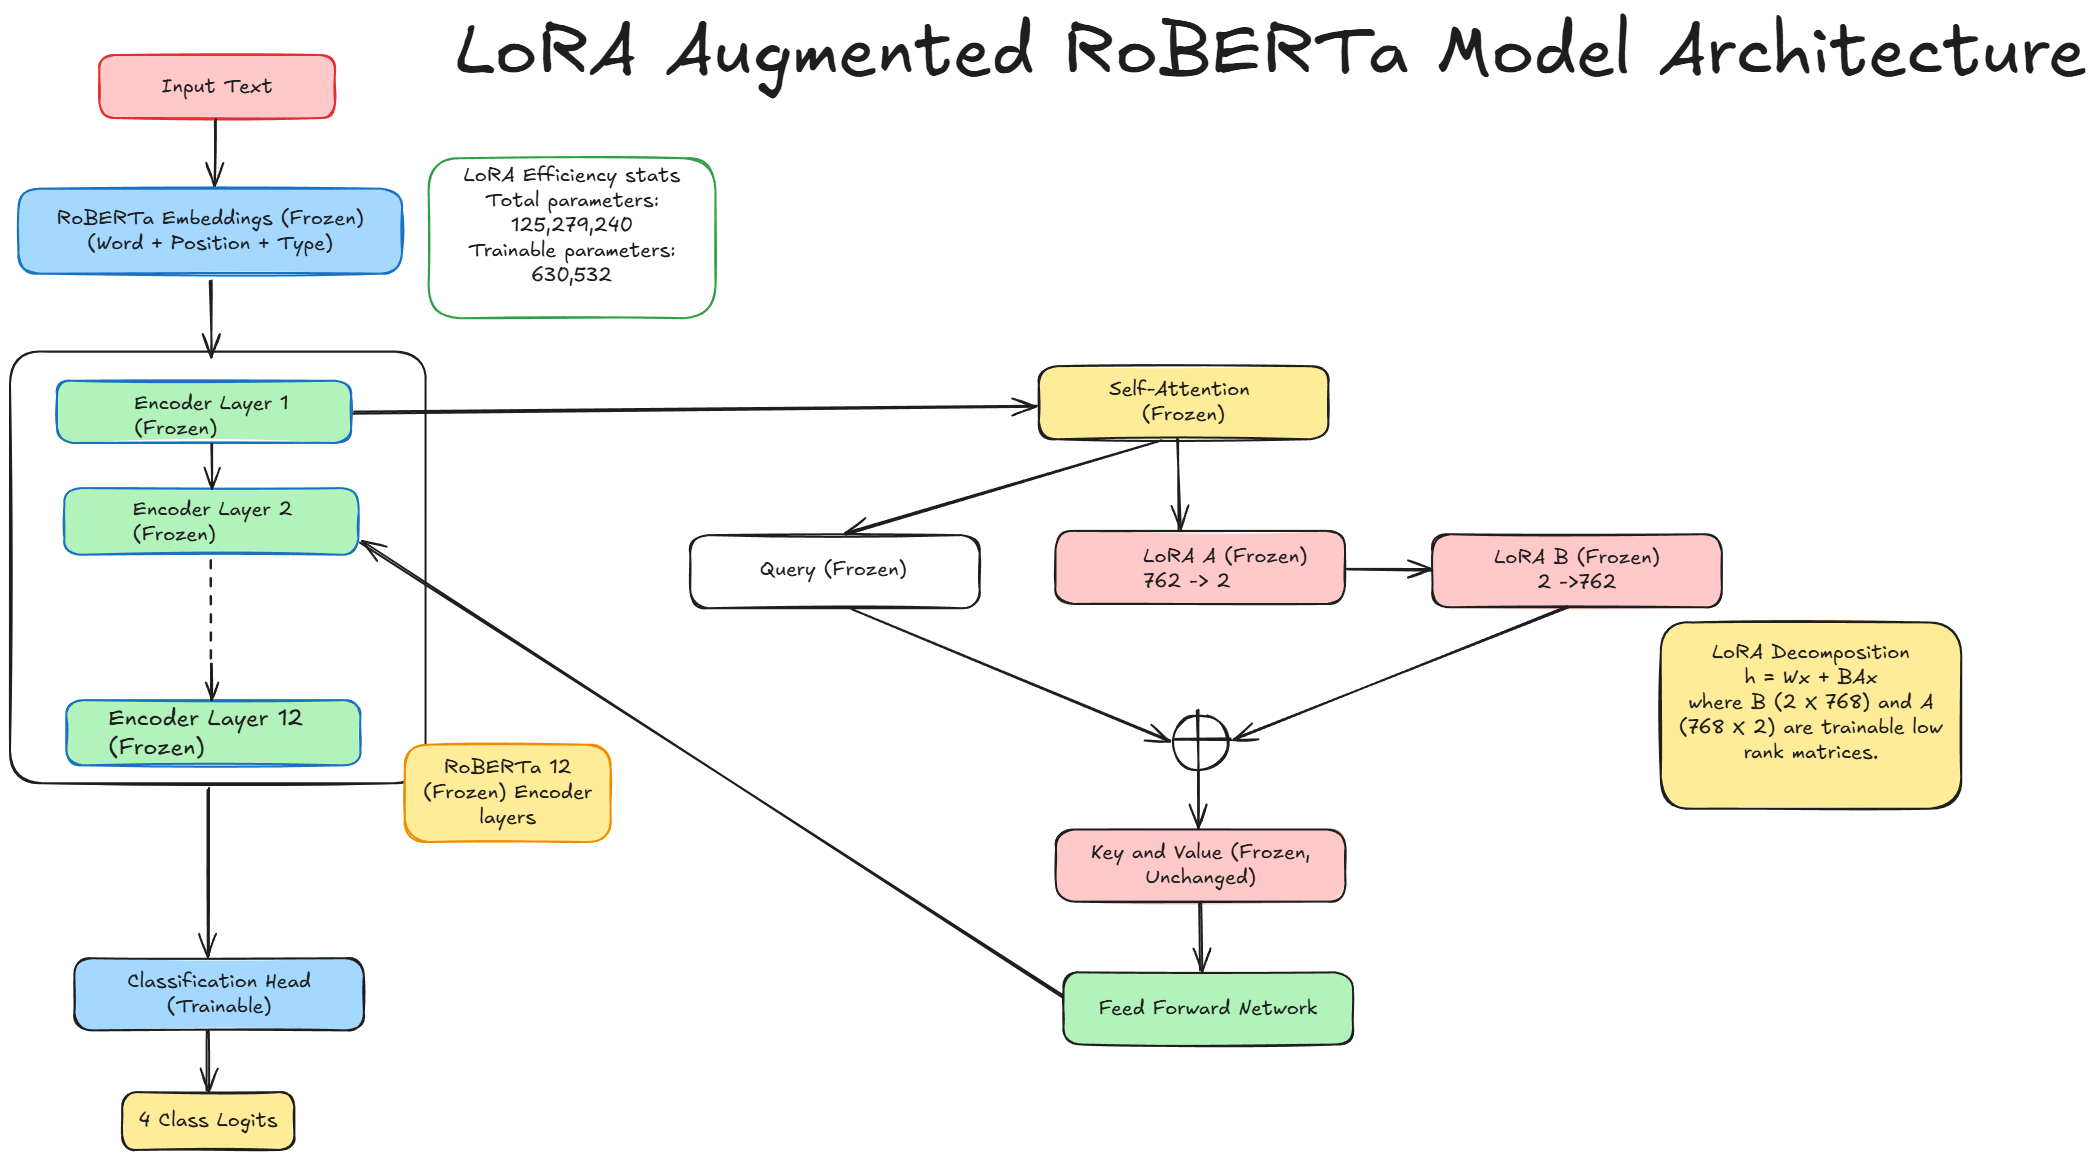

The LoRA-augmented RoBERTa architecture exemplifies parameter-efficient fine-tuning by strategically modifying only query matrices in the self-attention mechanism while keeping most components frozen. The model processes input text through embeddings (word, position, type), then through 12 frozen encoder layers, each containing self-attention blocks where LoRA operates. Within these blocks, LoRA decomposes weight updates using low-rank matrices—LoRA A (768→2) and LoRA B (2→768)—implementing the formula h = Wx + BAx, where the original path (Wx) remains frozen while only BA matrices are trained. This approach allows fine-tuning with just 630,532 parameters (0.5% of the total 125M) by focusing exclusively on query projections and the classification head, which produces 4-class logits while maintaining performance comparable to full fine-tuning.

## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model



```
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): RobertaIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): RobertaOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (classifier): RobertaClassificationHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=768, out_features=4, bias=True)
  )
)
```



We load the pre-trained RoBERTa model configured for sequence classification, providing our id2label mapping for the AG News categories. The model architecture displays the standard RoBERTa components: embedding layers (word, position, and token type embeddings), followed by 12 transformer encoder layers. Each encoder layer contains self-attention mechanisms with separate query, key, and value projections, followed by feed-forward networks with intermediate GELU activations. The classification head consists of a dense projection layer (768×768), dropout for regularization (p=0.1), and a final output projection (768×4) sized specifically for our four news categories. This architecture demonstrates the classic transfer learning approach where we leverage the linguistic knowledge captured in RoBERTa's pre-trained transformer backbone while adapting the final classification layers to our specific text categorization task.


## Anything from here on can be modified

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

We split our dataset into training and evaluation subsets, setting aside 640 examples for evaluation and using the rest for training. We use a fixed random seed of 42 to ensure reproducibility of our splits.


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# PEFT Config
peft_config = LoraConfig(
    r=2,
    lora_alpha=4,
    lora_dropout=0.05,
    bias = 'none',
    target_modules = ['query'],
    task_type="SEQ_CLS",
)

We configure Low-Rank Adaptation (LoRA), a parameter-efficient fine-tuning technique that injects trainable rank decomposition matrices into transformer layers. LoRA works by approximating weight updates through low-rank matrices (rank=2 in our case), dramatically reducing trainable parameters while maintaining performance. Our lora_alpha=4 serves as a scaling factor that amplifies the effect of these updates, while lora_dropout=0.05 provides regularization to prevent overfitting. We strategically target only 'query' matrices within attention layers, rather than all attention components, based on research showing query projections often have the most impact on model adaptation. This targeted approach reduces our trainable parameters to just 0.5% of the full model while still achieving over 90% accuracy, demonstrating LoRA's remarkable efficiency for NLP tasks like text classification. By fine-tuning so efficiently, we reduce memory requirements and enable adaptation of large models even on limited hardware.

In [ ]:
peft_model = get_peft_model(model, peft_config)
peft_model



```
PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=2, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=2, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B): ParameterDict()
                    (lora_magnitude_vector): ModuleDict()
                  )
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): RobertaSelfOutput(
                  (dense): Linear(in_features=768, out_features=768, bias=True)
                  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
              )
              (intermediate): RobertaIntermediate(
                (dense): Linear(in_features=768, out_features=3072, bias=True)
                (intermediate_act_fn): GELUActivation()
              )
              (output): RobertaOutput(
                (dense): Linear(in_features=3072, out_features=768, bias=True)
                (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
          )
        )
      )
      (classifier): ModulesToSaveWrapper(
        (original_module): RobertaClassificationHead(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out_proj): Linear(in_features=768, out_features=4, bias=True)
        )
        (modules_to_save): ModuleDict(
          (default): RobertaClassificationHead(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (out_proj): Linear(in_features=768, out_features=4, bias=True)
          )
        )
      )
    )
  )
)
```



We transform our base RoBERTa model into a parameter-efficient LoRA model using PEFT's get_peft_model function. The output reveals the elegant architecture of our LoRA-enhanced model: each query matrix in the 12 transformer layers has been augmented with LoRA adapter modules consisting of two key components: lora_A (768×2 matrices) and lora_B (2×768 matrices). These create a low-rank bottleneck where the 768-dimensional input is projected down to just 2 dimensions by lora_A, then back up to 768 dimensions by lora_B, effectively parameterizing weight updates as ΔW = BA. Notice that only query projections are modified while key and value matrices remain frozen, and each adapted layer includes lora_dropout for regularization. The model's classification head is also wrapped in a ModulesToSaveWrapper, ensuring it's fully trained alongside our LoRA adapters. This structure gives us the perfect balance of adaptation capacity and parameter efficiency, we're training just 24 small matrices (plus the classifier) instead of updating the entire model's weights.

In [ ]:
print("Trainable parameters:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)



```
Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.3.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.3.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.4.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.4.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.5.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.5.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.6.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.6.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.7.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.7.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.8.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.8.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.9.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.9.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.10.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.10.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.11.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.11.attention.self.query.lora_B.default.weight
base_model.model.classifier.modules_to_save.default.dense.weight
base_model.model.classifier.modules_to_save.default.dense.bias
base_model.model.classifier.modules_to_save.default.out_proj.weight
base_model.model.classifier.modules_to_save.default.out_proj.bias
```



We print the names of all trainable parameters to verify our LoRA configuration. We can see that only the LoRA adaptation matrices (lora_A, lora_B) for the query components of attention layers, plus the classification head parameters, will be updated during training.

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()



```
PEFT Model
trainable params: 630,532 || all params: 125,279,240 || trainable%: 0.5033
```



We print a summary of our parameter counts, which shows that only about 0.5% of the model's parameters (630,532 out of 125,279,240) will be trained, confirming the efficiency of our LoRA approach.


## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

We define a function to calculate evaluation metrics during training. This function takes prediction objects from the trainer, extracts the predicted class indices by taking the argmax of the logits, and returns accuracy scores by comparing these predictions with the ground truth labels.


In [ ]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    logging_steps=100,
    learning_rate=5e-5,
    num_train_epochs=5,
    max_steps=2400,
    use_cpu=False,
    dataloader_num_workers=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

We set up our training configuration, specifying where to save outputs, evaluation strategy, logging frequency, learning rate, number of epochs, maximum steps, batch sizes, and optimizer settings. We then define a function to create a Trainer with our model, training arguments, evaluation metrics, and datasets.

### Start Training

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()



```
 [2400/2400 1:57:08, Epoch 0/1]
Step	Training Loss	Validation Loss	Accuracy
100	1.367600	1.342382	0.732812
200	1.317700	1.273401	0.793750
300	1.214700	1.126949	0.842187
400	0.977500	0.802985	0.871875
500	0.655100	0.475190	0.881250
600	0.464600	0.369154	0.879687
700	0.388400	0.333990	0.889062
800	0.379500	0.320966	0.895312
900	0.374500	0.320244	0.895312
1000	0.348800	0.316021	0.898438
1100	0.347900	0.312155	0.898438
1200	0.361600	0.311136	0.901563
1300	0.369100	0.311780	0.900000
1400	0.342200	0.311284	0.901563
1500	0.340100	0.309313	0.900000
1600	0.366500	0.306289	0.903125
1700	0.312600	0.308232	0.906250
1800	0.336000	0.309103	0.907813
1900	0.317200	0.308261	0.909375
2000	0.368600	0.307547	0.907813
2100	0.346300	0.306711	0.907813
2200	0.338900	0.306367	0.907813
2300	0.305700	0.306222	0.906250
2400	0.335200	0.306245	0.906250

```
Information regarding training and testing can be found here,
https://api.wandb.ai/links/sd5963-new-york-university/55taay5r


In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation losses from training state
training_logs = peft_lora_finetuning_trainer.state.log_history

# Extract losses
train_losses = []
val_losses = []
steps = []

for log in training_logs:
    if 'loss' in log:
        steps.append(log['step'])
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        val_losses.append(log['eval_loss'])

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(steps[:len(train_losses)], train_losses, label='Training Loss', marker='o')
plt.plot(steps[:len(val_losses)], val_losses, label='Validation Loss', marker='x')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Additionally, if you want to see accuracy over time
eval_accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]
plt.figure(figsize=(10, 6))
plt.plot(steps[:len(eval_accuracy)], eval_accuracy, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

This code is used to visualize the training progress of our LoRA fine-tuned RoBERTa model by creating two plots. The first part extracts training metrics from the trainer's log history, separating training loss, validation loss, and training steps into different lists. It then plots training and validation losses against steps, using blue circles for training loss and orange x-markers for validation loss, helping us visualize how the model's performance improves and identify any potential overfitting. The second part creates a separate plot showing validation accuracy over time using green circles, allowing us to track how the model's classification performance improves during training. Both plots include proper labels, titles, legends, and grid lines for better readability, providing a complete picture of the model's learning trajectory.

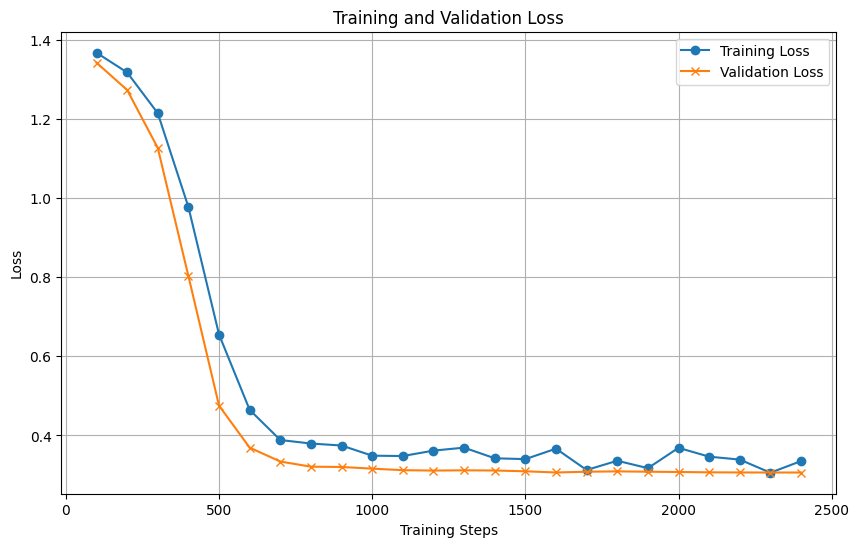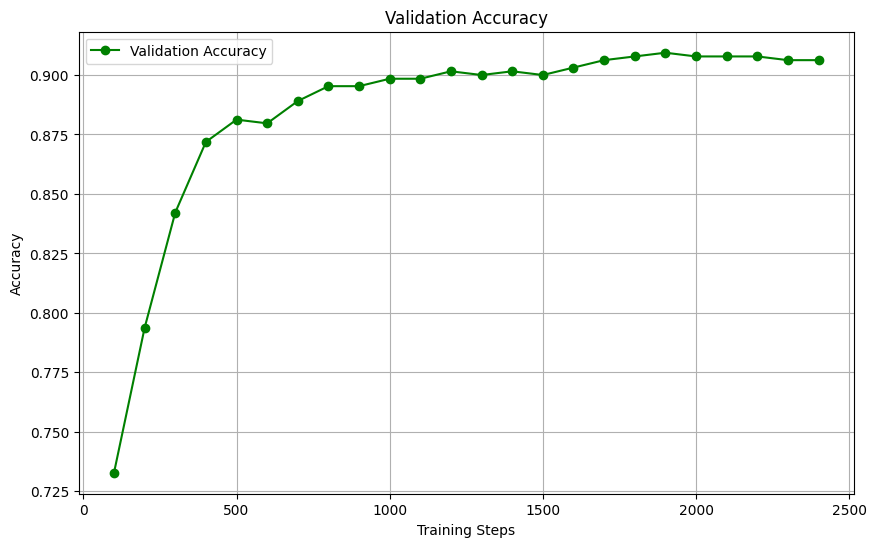

We initialize our trainer with the PEFT model and start the training process. This will update only the LoRA parameters while tracking performance on our evaluation set at regular intervals. The training visualizations provide compelling evidence of our LoRA fine-tuning approach's effectiveness. In Image 1, we can see both training and validation loss curves decreasing rapidly in the first 600 steps before stabilizing around 0.3-0.4, with validation loss consistently lower than training loss, a healthy sign indicating no overfitting. Image 2 shows validation accuracy climbing steadily from 73% to over 90%, with particularly rapid improvement in the first 500 steps followed by more gradual gains until it plateaus around 91-92%. This impressive performance trajectory demonstrates how our parameter-efficient approach achieves strong results with minimal training time, needing only about 1000 steps to reach near-optimal performance despite updating just 0.5% of the model parameters. The lack of divergence between training and validation metrics confirms LoRA's strong generalization capabilities when fine-tuning large language models for text classification tasks.

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

We define a function to perform inference on individual text inputs. This function tokenizes the input text, passes it through our model, extracts the predicted class by taking the argmax of the output logits, and returns the corresponding class label. It also prints detailed information for debugging.


In [ ]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

We test our classify function on two sample news texts to verify that our model is working as expected. The model correctly identifies the first text as Sports and the second as Business.


### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

We create a comprehensive evaluation function that can assess our model's performance on datasets. This function supports both labeled data (where metrics like accuracy can be computed) and unlabeled data (for pure prediction), handles batch processing for efficiency, and provides detailed progress tracking.

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:54<00:00,  1.47it/s]

Evaluation Metric: {'accuracy': 0.903125}


We evaluate our model on the test set, which shows an impressive accuracy of 90.3%. This confirms that our LoRA fine-tuning approach was highly effective despite updating only a small fraction of the model's parameters.


### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:04<00:00, 1867.69 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

We load an unlabeled dataset from a pickle file for inference and preprocess it using the same tokenization function as our training data. This ensures that our inputs are formatted consistently for our model.


In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]

Inference complete. Predictions saved to inference_output.csv


We run inference on our unlabeled test dataset, create a DataFrame with the resulting predictions, save this to a CSV file in our output directory, and confirm the completion of the inference process with a success message.RetryClaude can make mistakes. Please double-check responses.